# high level overview
Building makemore Part 3: Activations & Gradients, BatchNorm
- [Building makemore Part 3: Activations & Gradients, BatchNorm](https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4)
- building intuitive understanding of MLP activations & the gradient flows
    - focus on the history of the development of these networks
- while RNN are very capable, they are not very easily optimized given gradient flow
    - the kkey to understanding that is to better understand gradient flows

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

# largely recreating our setup from before
- pulling in our same data set & initializing the model based on what we had before
- we refactored to create a new variable hpreact (hidden layer pre-activations)
- this will be useful when we normalize later on

In [2]:
words = open('../building_makemore_p1/names.txt', "r").read().splitlines()
chars = sorted(list(set(''.join(words))))
char_to_index = {s:i+1 for i,s in enumerate(chars)}
char_to_index["."] = 0
index_to_char = {i:s for s,i in char_to_index.items()}

vocab_size = len(index_to_char)
block_size = 3 #how many characters does it take to predict the next one

def build_dataset(data):
    X, Y = [], []
    for w in data:
        context = [0] * block_size
        for ch in w + '.':
            ix = char_to_index[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # context gains a character and loses one to keep the length the same
    X = torch.tensor(X)    
    Y = torch.tensor(Y)    
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*(len(words)))
n2 = int(0.9*(len(words)))

Xtr, Ytr = build_dataset(words[:n1])
Xvalid, Yvalid = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])


# MLP
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) 
b1 = torch.randn(n_hidden, generator=g) 
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

# slight refactoring for training loop

lossi = []
max_steps = 200000
batch_size = 32

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1) # -1 means it figures out right size automatically (provided its possible with data)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)


    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

11897
      0/ 200000: 26.8331
  10000/ 200000: 2.7068
  20000/ 200000: 2.2270
  30000/ 200000: 2.3440
  40000/ 200000: 2.6338
  50000/ 200000: 2.6882
  60000/ 200000: 1.8862
  70000/ 200000: 2.4538
  80000/ 200000: 2.5564
  90000/ 200000: 2.4214
 100000/ 200000: 1.9883
 110000/ 200000: 1.8763
 120000/ 200000: 2.0932
 130000/ 200000: 1.8209
 140000/ 200000: 2.1569
 150000/ 200000: 2.2318
 160000/ 200000: 2.1595
 170000/ 200000: 2.0698
 180000/ 200000: 2.0694
 190000/ 200000: 2.1805


# quick validation below
- we use the below code to see how the model performs on the training and validation sets
- we use the annotation @torch.no_grad() to tell pytorch not to track any gradiants during this run (we won't be doing a backward pass here)
    - we then repeat our training code run here without the backward propagation

In [3]:
# context manager can also be used with torch.no_grad()
@torch.no_grad() # disables gradient tracking (less data passed means it runs faster)
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xvalid, Yvalid),
        'test': (Xtest, Ytest)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
    

train 2.125164031982422
val 2.1654465198516846


## sampling from model
- last time I did not include how to do an inference
- this is showing the auto-regressive nature of our model (we keep looping adding the last output to the new input)
- it's the same code as we use for training, only we take the logits at the end, sample from them like a probability distribution and use those to pick the next token

In [4]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 + b1
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1) # dimension = here is to say what should be condensed (T)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item() # pick one tensor to keep going with
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0: # 0 is special character . meaning to stop
            break

    print("".join(index_to_char[i] for i in out)) # actually print what we have

    # close, but no cigar

carpahra.
jeli.
khi.
mili.
taty.
skaelene.
mahnen.
amerynco.
aqui.
nellara.
chaiir.
kaleigh.
ham.
joce.
quint.
sulin.
alianni.
watelo.
dearyn.
kakael.


# Exploring Our Loss Graph
- from the below graph, we can see that our initial loss is very high and then quickly comes down
- we would expect the initial loss to be closer to the random chance of guessing right
    - in our case this is 1/27 (as we have 27 tokens)
    - from a logit point of view, that means that our tensor is full of basically identical values
- if the gradients also happen to be very far apart from each other (ie less uniform), this can also prompt our gradient to go off the rails
    - comparing the logits example vs the bad_logits, we see that the loss is dramatically different and this can result in HUGE updates being made, potentially pushing our neurons into dead neuron territory (more on this later)
- this is pushing us to be more careful with our initializations (random can be dangerous)

tensor(3.2958)
tensor([0.2500, 0.2500, 0.2500, 0.2500]) tensor(1.3863)
tensor([4.5394e-05, 9.9986e-01, 4.5394e-05, 4.5394e-05]) tensor(10.0001)


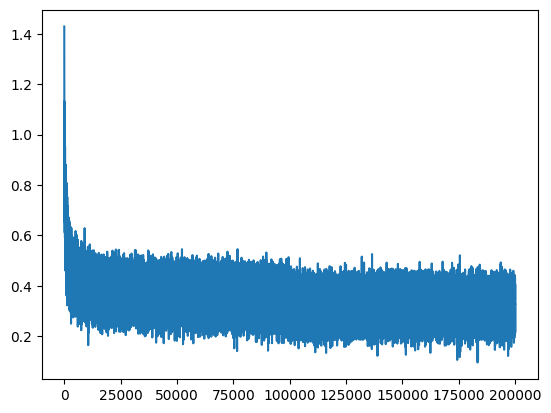

In [5]:
plt.plot(lossi)
expected_initial_loss = -torch.tensor(1/27.0).log()
print(expected_initial_loss)

# toy examples of what we expect that to look like if vocab was size 4
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0) # dim 0 because we only have 1 dimensino 
loss = -probs[2].log()
print(probs, loss)

bad_logits = torch.tensor([0.0, 10.0, 0.0, 0.0])
probs = torch.softmax(bad_logits, dim=0) # dim 0 because we only have 1 dimensino 
loss = -probs[2].log()
print(probs, loss)
# this is why what we initialize cannot be perfectly random (randn)

# Fixing Initialization
## Scaling Weights
- we want to reach an intial loss of 3.2958 ( loss with random guess)
- we don't want our last layer weights and biases to be overly confident
    - we are zeroing out the biases (there's no reason to start off assuming we know these, we'll let gradient descent determine)
    - we will then set the weights to be very small (0.01 rather than 0 because we want to leverage some entropy when training these weights)
    { have chatgpt give this a crack on why}
- just the above change, brings our loss from ~25 to ~4

11897
      0/ 200000: 3.2930
  10000/ 200000: 2.1783
  20000/ 200000: 2.1836
  30000/ 200000: 1.7959
  40000/ 200000: 2.5227
  50000/ 200000: 2.5933
  60000/ 200000: 2.3935
  70000/ 200000: 1.7195
  80000/ 200000: 2.3227
  90000/ 200000: 1.8610
 100000/ 200000: 2.0969
 110000/ 200000: 1.9654
 120000/ 200000: 1.9637
 130000/ 200000: 2.3023
 140000/ 200000: 1.8081
 150000/ 200000: 2.0576
 160000/ 200000: 2.4910
 170000/ 200000: 1.8572
 180000/ 200000: 2.0968
 190000/ 200000: 2.0880


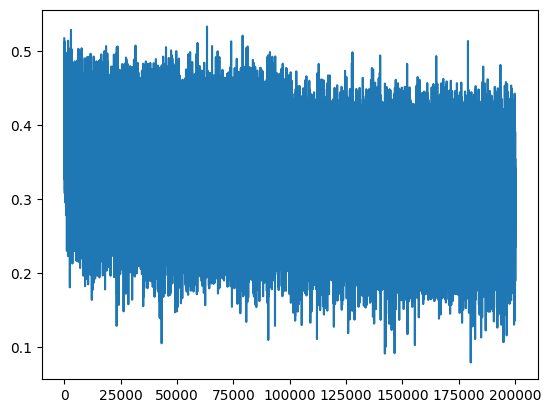

In [6]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) 
b1 = torch.randn(n_hidden, generator=g) 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # scaling this down so when we add this to the first piece it is smaller
b2 = torch.randn(vocab_size, generator=g) * 0 # we don't want to add large numbers at the beginning, so this is initialized to 0

# just changing W2 & b2, we see our loss go from 25.3449 on the first round to 4.3573
# dropping W2 from 0.1 to 0.01 brings us closer (3.2956)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

lossi = []
max_steps = 200000
batch_size = 32

for i in range(max_steps):


    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)


    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

plt.plot(lossi) # lose the hockey-stick appearance of the graph
# we also see a pretty good improvement as we're spending more steps improving network rather than squashing weights

## Preactivations & Dead Neurons
- looking at our hidden state at the end of the run  (`h`), we can see that there is an unexpected density of them at the 2 extremes (-1, and 1)
    - this is a problem, as our activation function (tanh) is a squashing function, meaning that at the extremes the derivative returns 0 (passing nothing through)
        - note this works for other squashing functions like gelu, relu, and sigmoids
    - so if at the end, a huge number of our neurons are dead (meaning clustered at -1 and 1), then we have likely wasted a lot of training time
- when we visualize our preactivations (hpreact) we can see that our values here are large (and thus will derive closer to 0)
- using the absolution value of our preactivations, we can see what portion of them are above 1 (the point which tanh will go to zero)
    - if an entire row of the graph is white, then we say that the neuron is dead (nothing will be passed through)
    - our goal here is to avoid this situation

tensor([[-1.0000, -0.9957, -1.0000,  ...,  1.0000, -0.9998, -1.0000],
        [-0.9992, -0.8033,  0.9995,  ..., -1.0000,  0.9992,  1.0000],
        [ 0.9883, -0.0462,  1.0000,  ..., -1.0000, -0.9888,  0.9992],
        ...,
        [-1.0000,  0.9964, -1.0000,  ...,  1.0000, -1.0000,  1.0000],
        [ 1.0000,  0.7615, -1.0000,  ..., -1.0000, -1.0000,  0.4433],
        [-0.5979, -0.9996, -0.6808,  ...,  1.0000, -1.0000, -1.0000]],
       grad_fn=<TanhBackward0>)


(array([2173.,  136.,   79.,   70.,   48.,   47.,   52.,   29.,   36.,
          35.,   34.,   28.,   28.,   26.,   44.,   16.,   22.,   18.,
          16.,   27.,   21.,   10.,   15.,   14.,   14.,    6.,   18.,
          22.,   16.,   26.,   15.,   24.,   13.,   17.,   33.,   25.,
          21.,   25.,   26.,   30.,   29.,   26.,   36.,   51.,   38.,
          48.,   67.,   90.,  148., 2512.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

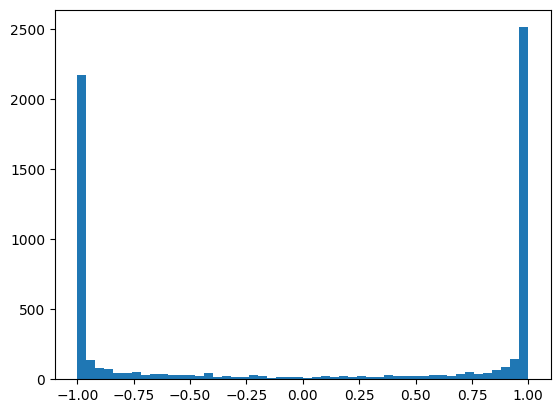

In [7]:
print(h)
h_as_list = h.view(-1).tolist() # convert to 1 long list of floats
plt.hist(h_as_list, 50)

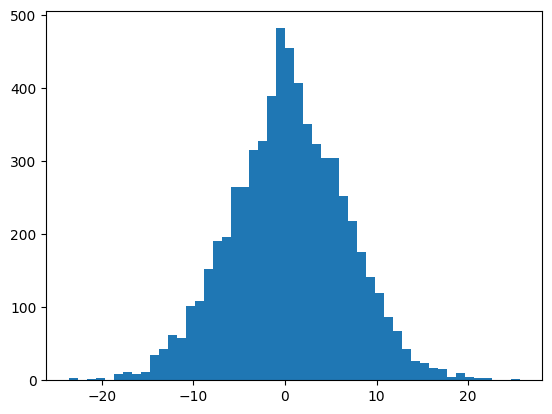

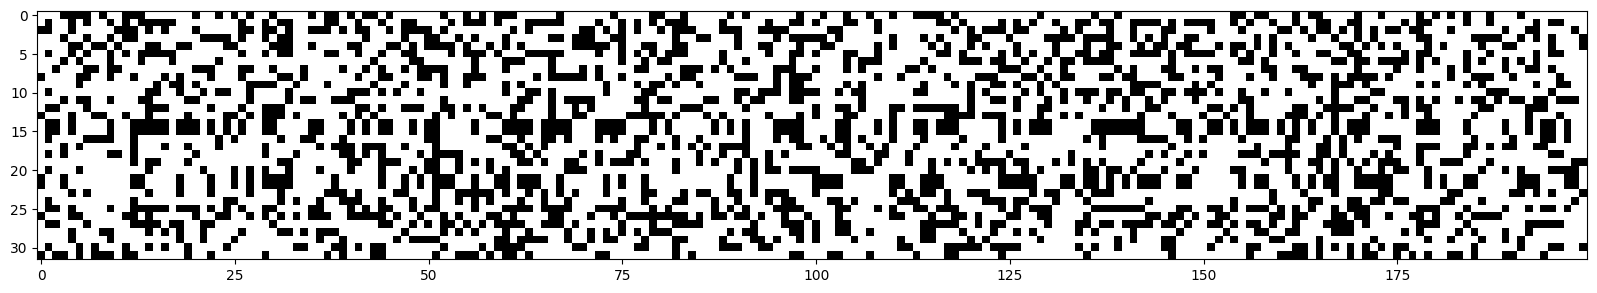

In [8]:
# looking at the preactivations
plt.hist(hpreact.view(-1).tolist(), 50)

plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')


## adjusting to fix dead neurons
- to avoid this, we will adjust our initial weights and biases to make these small
    - we arbitrairly choose 0.2 for W1 and 0.01 for biases (the idea is to make these very small, but allow for variation to maintain entropy)
- looking at just the first step, we can see that the neuron saturation is very limited, and the hidden state values are much more evenly distributed
- we didn't run into the dead neuron trap for p2 because our neural network was relatively shallow (few neural networks)
    - keeping the gradient flowing is paramount in larger networks

11897
      0/ 200000: 3.2952


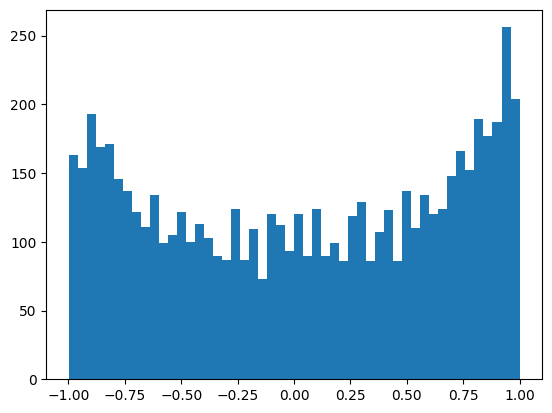

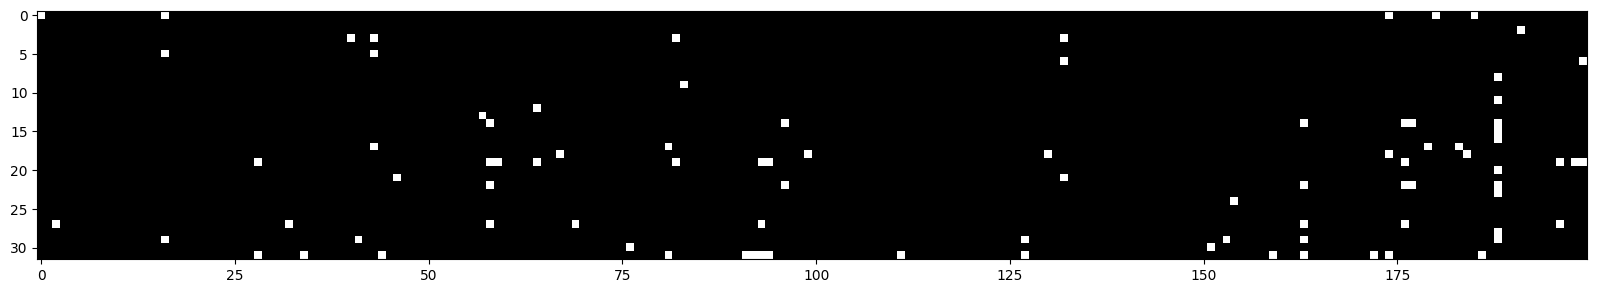

In [9]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * 0.2 
b1 = torch.randn(n_hidden, generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 
b2 = torch.randn(vocab_size, generator=g) * 0 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

lossi = []
max_steps = 200000
batch_size = 32

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)


    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

plt.hist(h.view(-1).tolist(), 50)
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

## Doing Full Run
- we can see our final loss is improved!

11897
      0/ 200000: 3.3042
  10000/ 200000: 1.9384
  20000/ 200000: 2.1293
  30000/ 200000: 2.2334
  40000/ 200000: 2.2222
  50000/ 200000: 2.1015
  60000/ 200000: 2.1964
  70000/ 200000: 2.2421
  80000/ 200000: 1.8440
  90000/ 200000: 2.3152
 100000/ 200000: 2.0317
 110000/ 200000: 1.8808
 120000/ 200000: 2.2201
 130000/ 200000: 2.1305
 140000/ 200000: 2.0477
 150000/ 200000: 2.0246
 160000/ 200000: 2.0807
 170000/ 200000: 1.8600
 180000/ 200000: 2.1577
 190000/ 200000: 1.8202


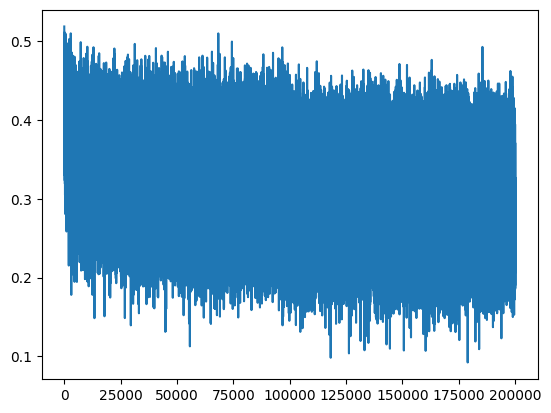

In [10]:
# doing a full run now
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * 0.2 
b1 = torch.randn(n_hidden, generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 
b2 = torch.randn(vocab_size, generator=g) * 0 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

lossi = []
max_steps = 200000
batch_size = 32

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)


    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

plt.plot(lossi)

# Explaining our Initialization Products
- We picked 0.02 somewhat randomly
- to get a more exact number we can follow the Kaiming Normal [from this paper](https://arxiv.org/abs/1803.08494)
    - this gives us gain / sqrt(fan_in)
    - fan_in is the dimensions of the incoming tensor coming into the weights
    - gain is determined by what type of activation function you use
        - we use (5/3) for tanh
- note, we don't have to be so careful with initializations if we use more modern optimizers (adam & AMAS as examples)
    - also note that pytorch handles a lot of this with built-in functions to avoid mistakes being made with initialization

tensor(0.0229) tensor(1.0044)
tensor(0.0031) tensor(0.9647)


(array([4.54174101e-04, 4.54174101e-04, 2.27087051e-04, 4.54174101e-04,
        1.13543525e-03, 4.54174101e-04, 1.58960935e-03, 4.54174101e-03,
        6.13135036e-03, 7.03969857e-03, 9.31056907e-03, 1.49877453e-02,
        2.56608367e-02, 4.42819749e-02, 6.04051554e-02, 9.19702555e-02,
        1.26941661e-01, 1.87346817e-01, 2.46843624e-01, 3.18148958e-01,
        3.89908466e-01, 4.23744436e-01, 4.49405273e-01, 4.34644615e-01,
        4.05350385e-01, 3.35861748e-01, 2.81815030e-01, 1.99609517e-01,
        1.53510846e-01, 1.13997699e-01, 6.85802893e-02, 4.40548878e-02,
        3.33817964e-02, 2.33899662e-02, 1.36252230e-02, 7.26678562e-03,
        6.35843741e-03, 2.04378345e-03, 2.27087051e-03, 1.81669640e-03,
        9.08348202e-04, 6.81261152e-04, 2.27087051e-04, 2.27087051e-04,
        2.27087051e-04, 0.00000000e+00, 2.27087051e-04, 0.00000000e+00,
        0.00000000e+00, 2.27087051e-04]),
 array([-4.99476528, -4.7745854 , -4.55440552, -4.33422564, -4.11404575,
        -3.89386587, 

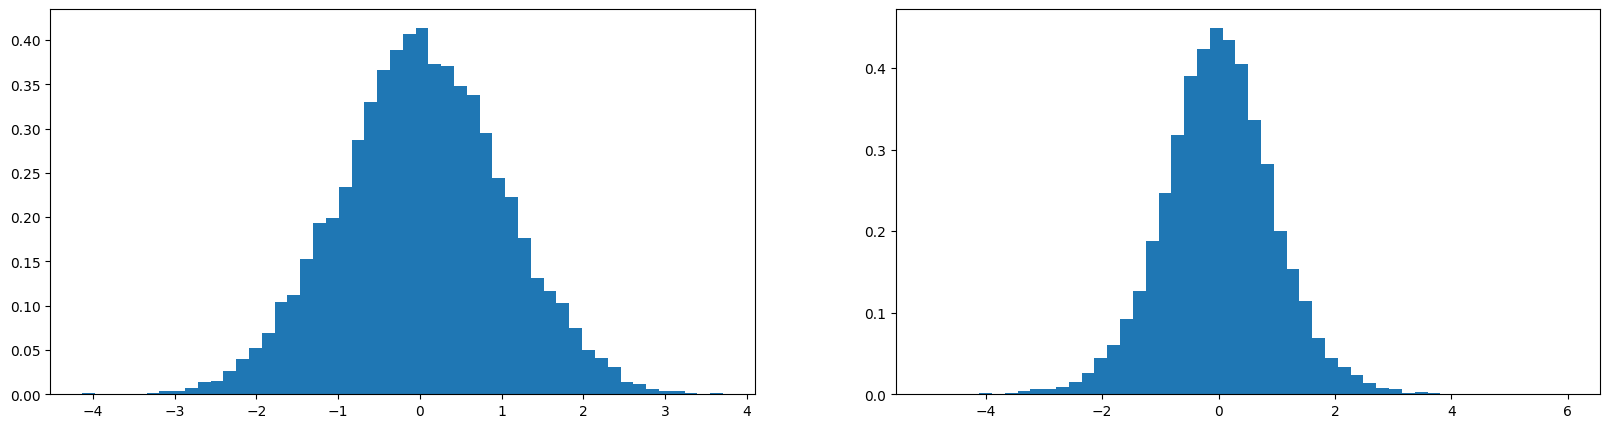

In [11]:
x = torch.randn(1000, 10)
w = torch.randn(10, 20) / 10**0.5
y = x @ w

print(x.mean(), x.std()) 
print(y.mean(), y.std())


plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

# doing our training run using kaiming initialization for W1

11897
      0/ 200000: 3.3079
  10000/ 200000: 1.9608
  20000/ 200000: 1.7935
  30000/ 200000: 2.4160
  40000/ 200000: 2.1331
  50000/ 200000: 2.1948
  60000/ 200000: 2.2573
  70000/ 200000: 1.7660
  80000/ 200000: 2.1410
  90000/ 200000: 2.5103
 100000/ 200000: 2.0540
 110000/ 200000: 2.1794
 120000/ 200000: 2.2930
 130000/ 200000: 2.2524
 140000/ 200000: 2.0140
 150000/ 200000: 1.6444
 160000/ 200000: 2.0792
 170000/ 200000: 2.2385
 180000/ 200000: 2.3108
 190000/ 200000: 1.4987


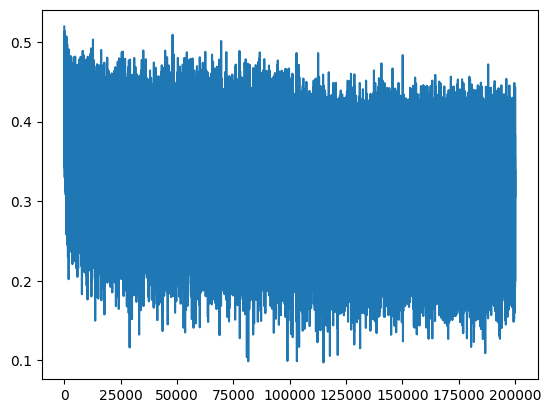

In [12]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * (5/3) / (n_emb*block_size)**0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

lossi = []
max_steps = 200000
batch_size = 32

for i in range(max_steps):


    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)


    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

plt.plot(lossi)

# Batch Normalization
- While we've initialized the weights better, we still have to worry about stability throughout the run
    - basically, if one neuron gets pushed too far consistently, it will still become a dead neuron
- we can fix this by adding a function before the activation function that normalizes our preactivations
    - this is the heart of batch normalization
        - we normalize it so the actiations follow a normal distribution
    - called batch normalization because the inputs here are always a batch (rather than an individual query from the batch)
- batch normalization comes from [this 2015 paper](https://arxiv.org/pdf/1502.03167) from DeepDmind
- this stability however comes at a cost
    - we are now mathematically coupling the batch together (meaning the output for an input WILL depend on the batch it is processed in)
    - this is not good logically, as the output should only care about the input
    - nevertheless, we find that this winds up being a regularizer (meaning it prevents the model from going off too far in one direction)
    - different normalizers (like layer, instance, and group) do not have this problem
- we are not expecting much improvement due to the shallowness of our model here, but this is necessary for deeper model

12297
      0/ 200000: 3.2797
  10000/ 200000: 2.3777
  20000/ 200000: 2.0432
  30000/ 200000: 2.1411
  40000/ 200000: 2.1115
  50000/ 200000: 2.1807
  60000/ 200000: 2.1481
  70000/ 200000: 2.4300
  80000/ 200000: 2.0338
  90000/ 200000: 2.3873
 100000/ 200000: 2.2794
 110000/ 200000: 2.4330
 120000/ 200000: 1.9664
 130000/ 200000: 2.4168
 140000/ 200000: 2.1168
 150000/ 200000: 1.8489
 160000/ 200000: 2.1683
 170000/ 200000: 2.2834
 180000/ 200000: 1.9136
 190000/ 200000: 1.8986


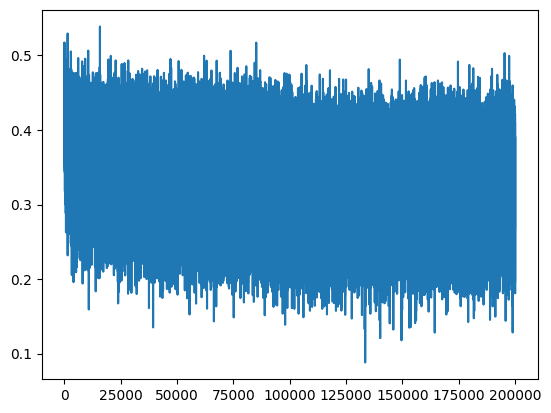

In [13]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * (5/3) / (n_emb*block_size)**0.5
b1 = torch.randn(n_hidden, generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0 

# new
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

lossi = []
max_steps = 200000
batch_size = 32

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # (batch_size, n_hidden) (32, 200)

    # standardization (along with our backpropagation telling us how to move this distribution)
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias

    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

plt.plot(lossi)


## Consequence of Batch Normalization
- we need to make a quick adjustment to our inference code so that we have the batch calculations (mean & std of the batch) to calculate the normalization
- note, we can also determine what the mean & std should be during training and then simply save that number to use during inference (more common approach, as it makes for more consistent inferencing)

In [14]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

@torch.no_grad() 
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xvalid, Yvalid),
        'test': (Xtest, Ytest)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())



split_loss('train')
split_loss('val')


train 2.0683629512786865
val 2.1089437007904053


## Batch Normalization Consequences Part 2: Removing bias
- as we are normalizing before we pass the data to our activation function, the addition we use to add in bias will have no effect
- consequently, we remove the b1 and b2 parameters from before and instead only use bnbias

12070
      0/ 200000: 3.2749
  10000/ 200000: 2.0513
  20000/ 200000: 2.2451
  30000/ 200000: 2.4005
  40000/ 200000: 2.0858
  50000/ 200000: 2.3982
  60000/ 200000: 2.4189
  70000/ 200000: 1.7357
  80000/ 200000: 1.9143
  90000/ 200000: 2.1474
 100000/ 200000: 2.0736
 110000/ 200000: 2.1799
 120000/ 200000: 2.2307
 130000/ 200000: 1.9092
 140000/ 200000: 2.2923
 150000/ 200000: 2.2157
 160000/ 200000: 2.0068
 170000/ 200000: 2.3914
 180000/ 200000: 2.2890
 190000/ 200000: 1.8651
train 2.068739175796509
val 2.108959913253784


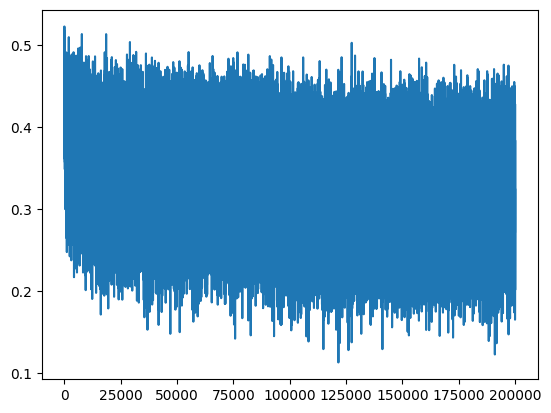

In [15]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * (5/3) / (n_emb*block_size)**0.5
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
# at the beginning we will have mean 0 and stdev 1
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

lossi = []
max_steps = 200000
batch_size = 32


for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1

    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    # note we are skipping the + epsilon here because for such a small model this is unlikely to change the results

    # simply being updated using direct running mean
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact) 
    logits = h @ W2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

plt.plot(lossi)

# this combines the two stages
@torch.no_grad() 
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xvalid, Yvalid),
        'test': (Xtest, Ytest)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) 
    logits = h @ W2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')


# part 2: pytorchifying our code
- we took our code from before and put it into classses that closely mirror PyTorch's (note the differences in the comments)
- goal is to have this look similar to how it would appear in pytorch

In [16]:
import torch
class Linear:
    # matches pytorch except for device and datatype (CPU and float respectively)
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    # forward pass
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    #affine is assumed to be True, tracking_running_stats is True, device is CPU, datatype is float
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True # should behave differently if running in eval or training

        self.gamma = torch.ones(dim) # = bngain
        self.beta = torch.zeros(dim) # = bnbias

        # buffers in pytorch nomenclature (NOT parameters)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    # from batch normalization paper (link: )
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean +self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [17]:
# building our model:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    layers[-1].weight *= 0.1 # reducing certainty at the beginning for weights
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= (5/3) # playing with the gain for weight initializations (5/3 is the ideal given kaiming initialization)

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


46497


In [18]:
# training:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # NOTE HERE
    for p in parameters:
        p.grad = None # zero out previous grads
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break # here so we can run the below debugging tools and check initialization

      0/ 200000: 3.2962


# Debugging Tools
- Now we go through different methods we can use to determine if we've made some mistake in our architecture
- Forward Pass Activations (out)
    - the below shows us displaying how many of the layers have a value above .97 (basically close to 1)
    - thie saturation percentage shows how many of a layer are dead
        - as we can see from the output, layer 1 is disproportionately saturated, suggesting we need to set a better gain
        - we don't want zero saturation, so we need to adjust

layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 20.25%
layer 3 (      Tanh): mean -0.00, std 0.69, saturated: 8.38%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 6.62%
layer 7 (      Tanh): mean -0.01, std 0.66, saturated: 5.47%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.12%


Text(0.5, 1.0, 'activation distribution')

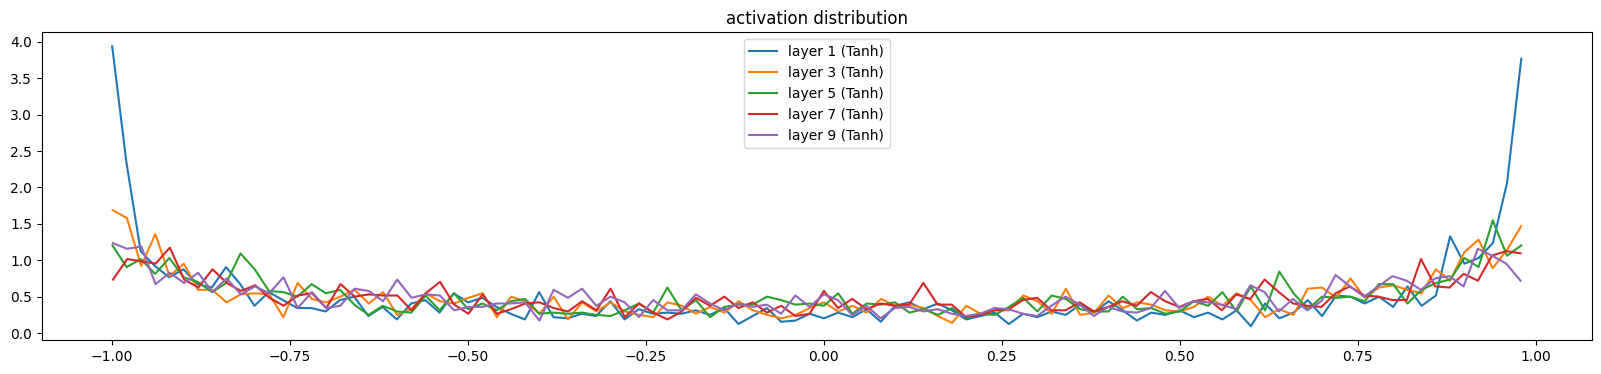

In [19]:
# visualize histogram of forward pass activations (tanH)
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        # saturation shows us how many neurons are dying
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title("activation distribution")

# Debugging Tools Part 2
- Backward Pass Activations (grad)
    - here, we are checking to see how many of the backwards passes can no longer pass data through
    - by getting the gradient to data ratio, we are able to determine if the gradients are vanishing (ratio is too small) or the gradients are exploding (ratio is too big)
        - this data will tell us if our normalization is working right
    - we can see on the graph that the activations are all grouped together
    - and the grad to data ratio of the last layer is very big compared to the rest
        - this means our last layer is getting updated SIGNIFICANTLY faster than the rest
            - this may mean the learning rate here should be adjusted or that we should do gradient clipping to avoid the gradients here getting above a certain level
        - note, the reason for us this is so different is we artifically shrunk all of the weights in the last layer by a factor of 0.1 before

weight   (27, 10) | mean -0.000031 | std 1.365078e-03 | grad:data ratio 1.364090e-03
weight  (30, 100) | mean -0.000049 | std 1.207430e-03 | grad:data ratio 3.871660e-03
weight (100, 100) | mean +0.000016 | std 1.096730e-03 | grad:data ratio 6.601988e-03
weight (100, 100) | mean -0.000010 | std 9.893572e-04 | grad:data ratio 5.893091e-03
weight (100, 100) | mean -0.000011 | std 8.623432e-04 | grad:data ratio 5.158124e-03
weight (100, 100) | mean -0.000004 | std 7.388577e-04 | grad:data ratio 4.415212e-03
weight  (100, 27) | mean +0.000000 | std 2.364824e-02 | grad:data ratio 2.328203e+00


Text(0.5, 1.0, 'activation distribution')

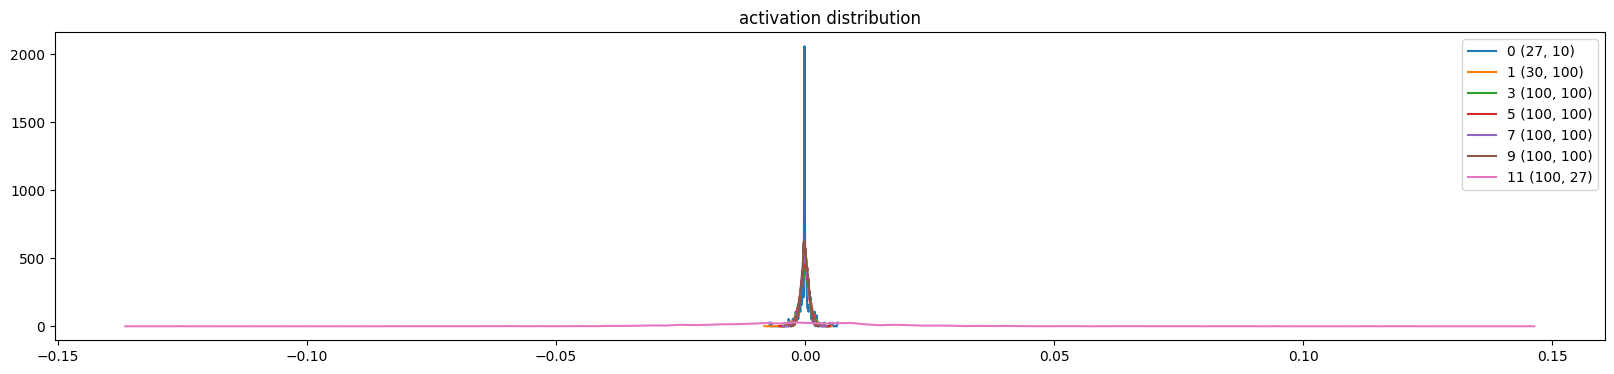

In [20]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim ==2:
        # saturation shows us how many neurons are dying
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title("activation distribution")

# using debugging tools after a proper run
- we are seeing that we get better losses, but still not where we want to be
- our gradient descent optimizer is likely not going to be good enough: this will push us to use a more modern optimizer like Adam

46497
      0/ 200000: 3.2962
weight   (27, 10) | mean +0.000980 | std 1.189170e-02 | grad:data ratio 1.189149e-02
weight  (30, 100) | mean +0.000118 | std 1.005290e-02 | grad:data ratio 3.214554e-02
weight (100, 100) | mean +0.000033 | std 7.821208e-03 | grad:data ratio 4.653360e-02
weight (100, 100) | mean -0.000107 | std 6.655619e-03 | grad:data ratio 3.925851e-02
weight (100, 100) | mean -0.000017 | std 6.086039e-03 | grad:data ratio 3.605767e-02
weight (100, 100) | mean -0.000077 | std 5.075620e-03 | grad:data ratio 3.015269e-02
weight  (100, 27) | mean -0.000000 | std 2.056585e-02 | grad:data ratio 2.909911e-01


Text(0.5, 1.0, 'activation distribution')

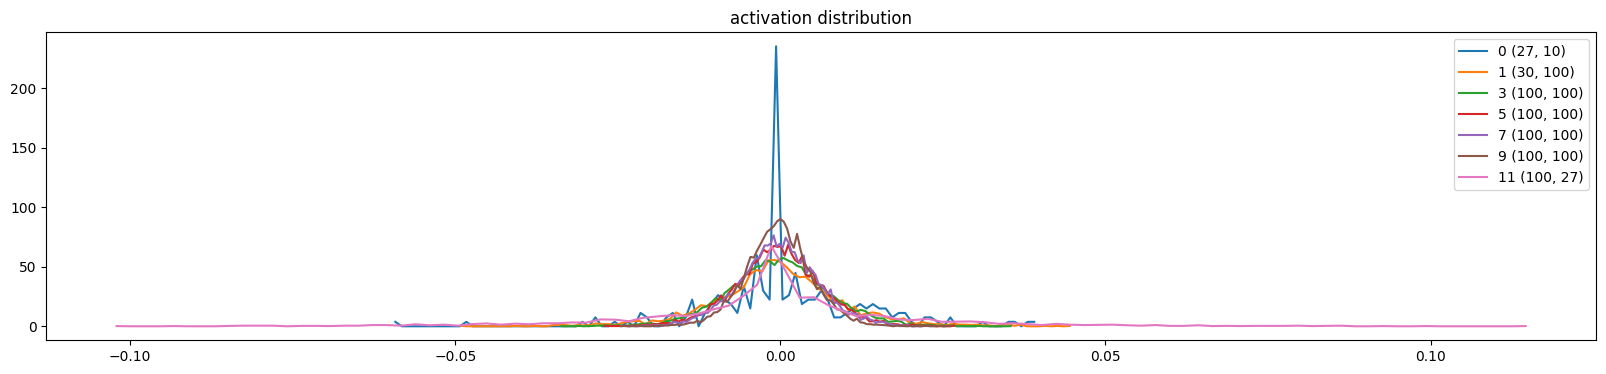

In [21]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    layers[-1].weight *= 0.1 
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= (5/3) 

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None # zero out previous grads
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log().item() for p in parameters])
    if i >= 1000:
        break

plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim ==2:
        # saturation shows us how many neurons are dying
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title("activation distribution")

# Analyzing Gradient to Data Ratios
- from the below, we can see how our gradient to data ratios varied over time
- Andrej uses 1e-3 as the baseline for where these updates should be
- if the layers are above that line, then we need to lower the learning rate
    - and below, vice versa

Text(0.5, 1.0, 'Update Ratios Over Time')

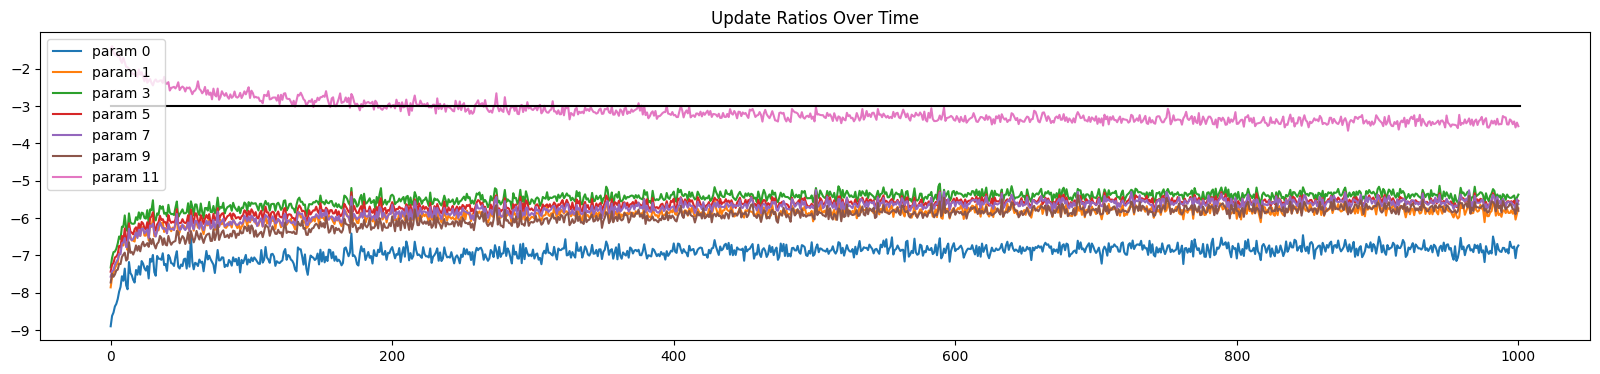

In [22]:
# update to data ratio matters most
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim ==2:
        # saturation shows us how many neurons are dying
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param %d' %i)
plt.plot([0, len(ud)], [-3,-3], 'k')
plt.legend(legends)
plt.title("Update Ratios Over Time")

# we see stabilization happening over training
# we expect that these ratios will be 1e-3 (which are)
# last layer was artificially shrunk down to avoid overconfidence (this is why temporarily we see a too high ratio)
# the evolution verifies that it's not too much above 1e-3
# if it's below -3 it means the parameters are not trained fast enough (way too slow)

# adjusting our learing rate based off this
- they were below the line, so  we go up

46497
      0/ 200000: 3.2962
weight   (27, 10) | mean -0.000860 | std 1.408817e-02 | grad:data ratio 1.342753e-02
weight  (30, 100) | mean +0.000117 | std 7.494034e-03 | grad:data ratio 2.086767e-02
weight (100, 100) | mean -0.000014 | std 4.434054e-03 | grad:data ratio 2.186667e-02
weight (100, 100) | mean +0.000009 | std 4.073396e-03 | grad:data ratio 2.018307e-02
weight (100, 100) | mean -0.000010 | std 4.949671e-03 | grad:data ratio 2.450682e-02
weight (100, 100) | mean +0.000025 | std 6.553927e-03 | grad:data ratio 3.914154e-02
weight  (100, 27) | mean +0.000000 | std 2.054140e-02 | grad:data ratio 2.080403e-01


Text(0.5, 1.0, 'Update Ratios Over Time')

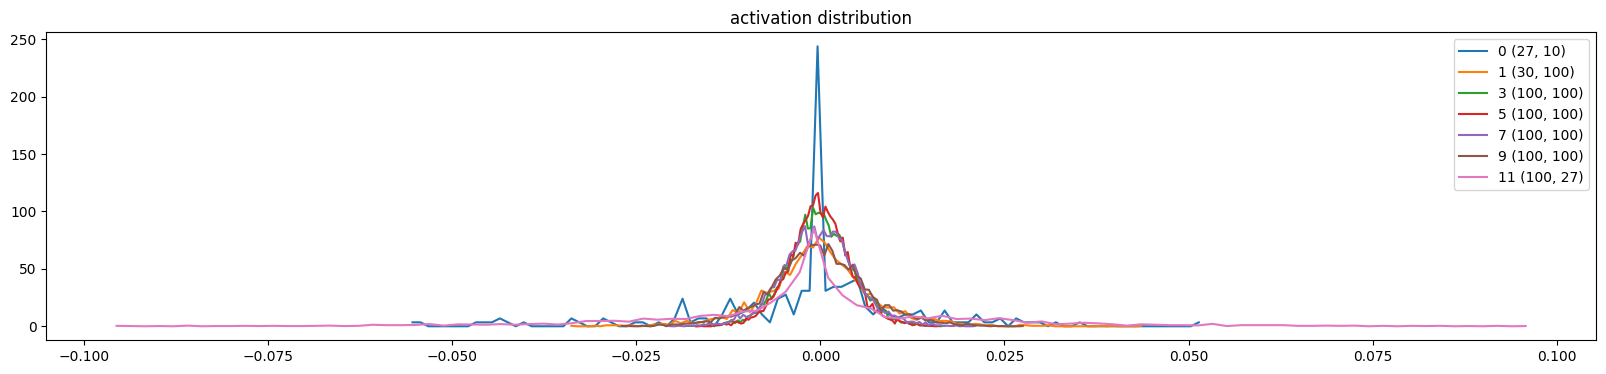

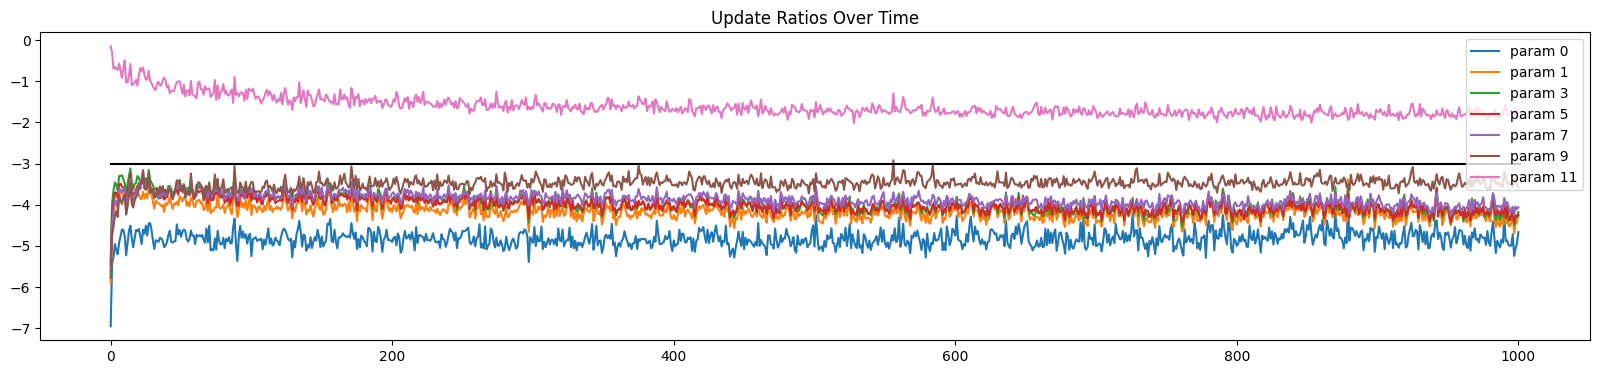

In [23]:
# better learning rate

max_steps = 200000
batch_size = 32
lossi = []
ud = []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    layers[-1].weight *= 0.1 # reducing certainty at the beginning for weights
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= (5/3) # playing with the gain for weight initializations

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # NOTE HERE
    for p in parameters:
        p.grad = None # zero out previous grads
    loss.backward()

    lr = 0.7 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log().item() for p in parameters])
    if i >= 1000:
        break

plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim ==2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title("activation distribution")

plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim ==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param %d' %i)
plt.plot([0, len(ud)], [-3,-3], 'k')
plt.legend(legends)
plt.title("Update Ratios Over Time")

# using debugging when we have a mistake
- we will purposefully remove our kaiming initialization calculation 
- look at how the graphs adjust to show something is wrong
    - HINT: we can clearly see the saturation is WAY too high (consequently, we are clued in to the mistake)

46497
      0/ 200000: 3.7560
layer 1 (      Tanh): mean +0.07, std 1.00, saturated: 99.94%
layer 3 (      Tanh): mean +0.01, std 0.99, saturated: 96.94%
layer 5 (      Tanh): mean +0.02, std 0.99, saturated: 95.06%
layer 7 (      Tanh): mean +0.02, std 0.98, saturated: 91.75%
layer 9 (      Tanh): mean +0.04, std 0.98, saturated: 90.78%


Text(0.5, 1.0, 'activation distribution')

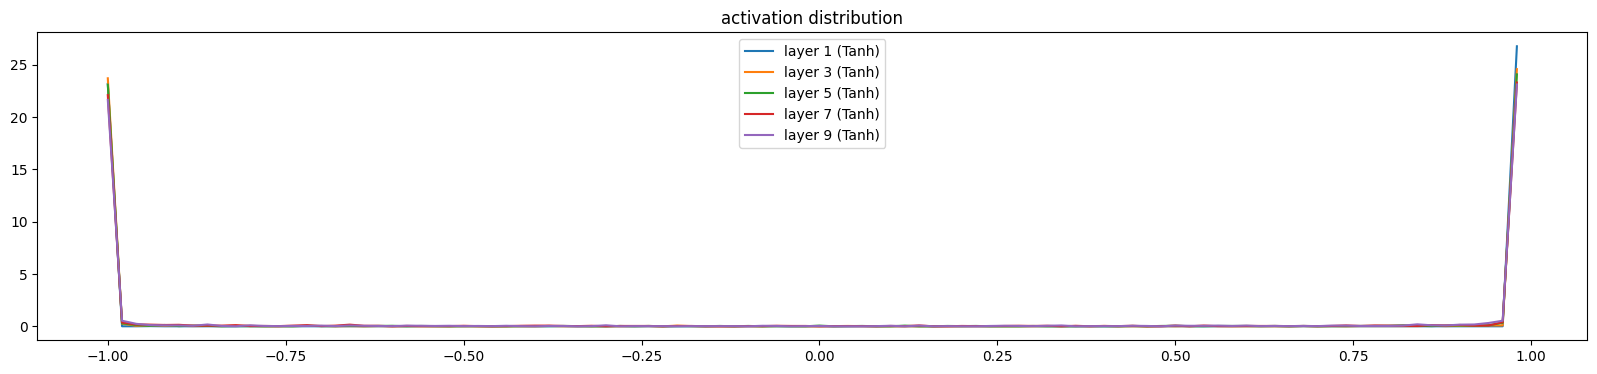

In [24]:
# when it goes wrong, what happens?
# remove fan_in
class Linear:
    # matches pytorch except for device and datatype (CPU and float respectively)
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator = g) # / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    # forward pass
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# better learning rate

max_steps = 200000
batch_size = 32
lossi = []
ud = []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    layers[-1].weight *= 0.1 # reducing certainty at the beginning for weights
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= (5/3) # playing with the gain for weight initializations

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # NOTE HERE
    for p in parameters:
        p.grad = None # zero out previous grads
    loss.backward()

    lr = 0.7 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log().item() for p in parameters])
    if i >= 1000:
        break

plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        # saturation shows us how many neurons are dying
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title("activation distribution")

# graphs from a healthy run

In [25]:
# resetting
class Linear:
    # matches pytorch except for device and datatype (CPU and float respectively)
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    # forward pass
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

47551
      0/ 200000: 3.2870
layer 2 (      Tanh): mean +0.03, std 0.69, saturated: 8.44%
layer 5 (      Tanh): mean -0.01, std 0.66, saturated: 2.62%
layer 8 (      Tanh): mean +0.01, std 0.65, saturated: 1.22%
layer 11 (      Tanh): mean +0.01, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean -0.04, std 0.70, saturated: 10.34%
weight   (27, 10) | mean -0.000000 | std 2.492276e-03 | grad:data ratio 1.746856e-03
weight  (30, 100) | mean +0.000010 | std 7.752377e-04 | grad:data ratio 1.640258e-03
weight (100, 100) | mean +0.000002 | std 3.205132e-04 | grad:data ratio 1.400134e-03
weight (100, 100) | mean +0.000001 | std 2.576701e-04 | grad:data ratio 1.200845e-03
weight (100, 100) | mean +0.000002 | std 2.523554e-04 | grad:data ratio 1.184423e-03
weight (100, 100) | mean +0.000000 | std 3.234611e-04 | grad:data ratio 1.447659e-03
weight  (100, 27) | mean +0.000003 | std 1.365280e-03 | grad:data ratio 2.957744e-03


Text(0.5, 1.0, 'Update Ratios Over Time')

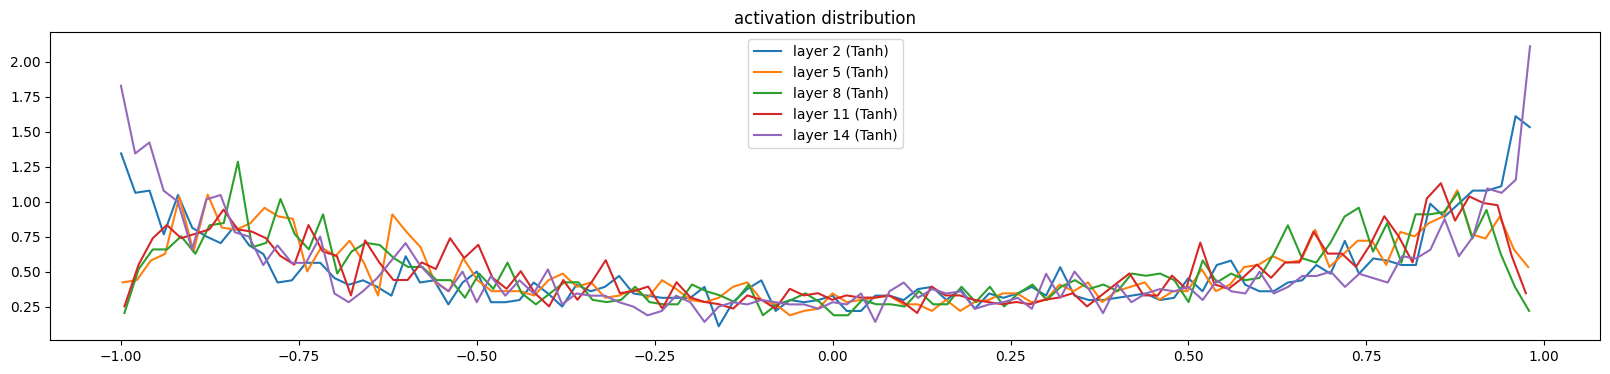

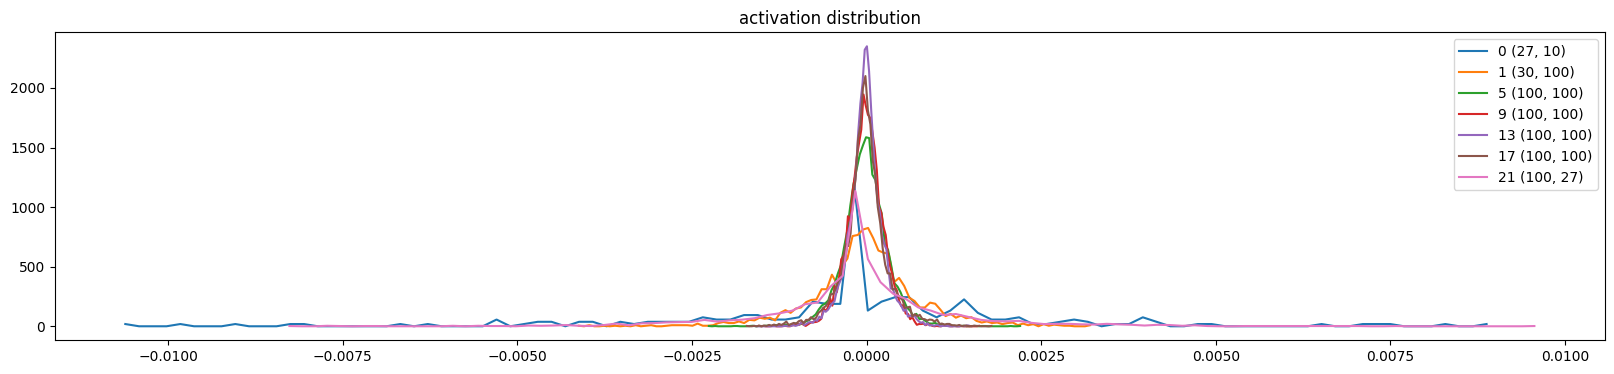

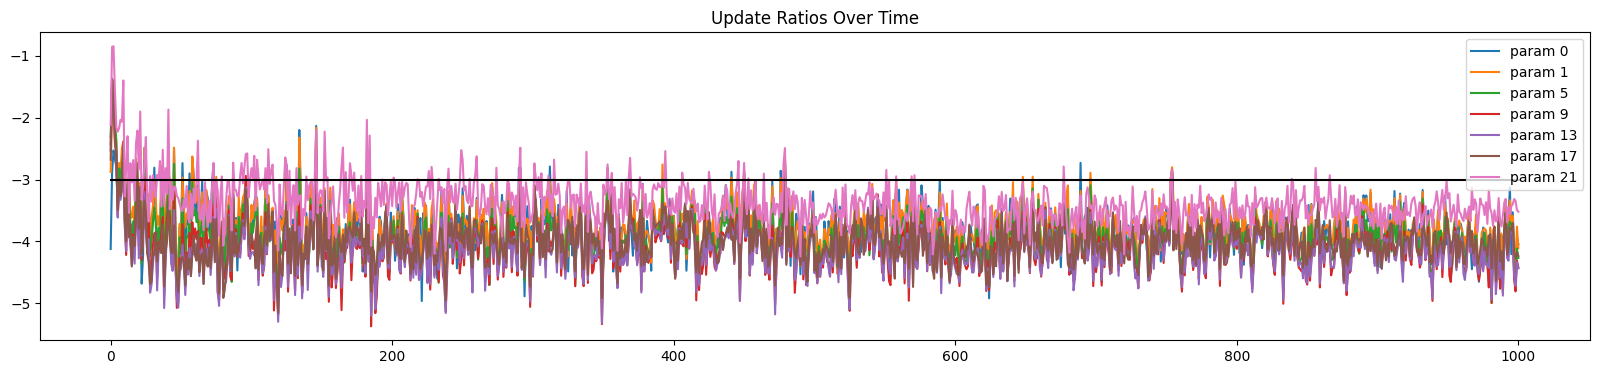

In [26]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
# standard place is after linear layer, but before the non-linearity (activation function)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size), 
]
# also find to place it at the end before the loss_function

with torch.no_grad():
    layers[-1].gamma *= 0.1 # reducing certainty at the beginning for our batch norm
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= (5/3) # playing with the gain for weight initializations

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # NOTE HERE
    for p in parameters:
        p.grad = None # zero out previous grads
    loss.backward()

    lr = 10 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log().item() for p in parameters])
    if i >= 1000:
        break

plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        # saturation shows us how many neurons are dying
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title("activation distribution")

plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim ==2:
        # saturation shows us how many neurons are dying
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title("activation distribution")

plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim ==2:
        # saturation shows us how many neurons are dying
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param %d' %i)
plt.plot([0, len(ud)], [-3,-3], 'k')
plt.legend(legends)
plt.title("Update Ratios Over Time")

# Closing
- batch norm makes us far more robust to the initializations 
- it seems our performance now is bottlenecked by context length >> 3 characters in a row
- now we need to look at more powerful architectures